# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Оглавление
___

[Подготовка](#5_preparing)<br>
[1. Изучение данных](#5_1.)<br>
[2. Подготовка выборок](#5_2.)<br>
[3. Исследование моделей](#5_3.)<br>
[3.1. Предварительная оценка моделей](#5_3.1)<br>
[3.2. Подбор гиперпараметров](#5_3.2)<br>
[4. Проверка качества модели](#5_4.)<br>
[5. Проверка на адекватность](#5_5.)<br>
[6. Вывод](#5_6.)<br>

<a id='5_preparing'></a>
# Подготовка

## Импорт библиотек

### Основные библиотеки

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import re
import warnings
warnings.filterwarnings("ignore")

### scikit-learn

In [2]:
from sklearn.metrics import accuracy_score, mean_squared_error

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
from sklearn.ensemble import RandomForestClassifier

### Библиотеки для работы с графиками

In [9]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps
import plotly.io as pio

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

### Настройки библиотек

In [10]:
# Меняем форматтер для отобраения вещественных чисел, чтобы приятно смотреть было на числа
pd.options.display.float_format = lambda x: f"{x:5,.6g}".replace(",", " ")

In [11]:
#Настраиваем графики
PLOTLY_TEMPLATE = pio.templates["ggplot2"]
PLOTLY_TEMPLATE["layout"].update(margin=dict(l=15,r=15,t=70,b=15,autoexpand=True), height=500, width=1000)
pio.templates.default = PLOTLY_TEMPLATE
pio.renderers.default = "png"
pio.kaleido.scope.default_scale = 1.5

mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = 16,8
mpl.rcParams["figure.dpi"] = 96
mpl.rcParams["savefig.dpi"] = 300

sns.set(); sns.set(rc={'figure.figsize':(16,8)})

<a id="5_1."></a>
# 1. Изучение данных

## Описание данных

* ***сalls*** — количество звонков,
* ***minutes*** — суммарная длительность звонков в минутах,
* ***messages*** — количество sms-сообщений,
* ***mb_used*** — израсходованный интернет-трафик в Мб,
* ***is_ultra*** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Читаем данные из файла:

In [12]:
users = pd.read_csv("./datasets/users_behavior.csv")

In [13]:
users.sample(10)

,calls,minutes,messages,mb_used,is_ultra
2812,29,215.89,27,18 411.3,0
283,40,334.5,0,21 505.6,0
858,30,178.8,45,22 732.7,0
1718,107,703.31,34,13 292,0
629,123,947.71,57,24 046.9,1
839,14,119.61,23,13 469.4,0
1386,92,536.96,18,20 193.9,0
586,6,51.08,16,20 635,1
2556,155,932.62,77,27 627.7,1
1168,54,374.45,13,19 344.8,0


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Данные успешно загружены, в них пропусков нет, тип данных корректный. Можем идти дальше!

<a id="5_2."></a>
# 2. Подготовка выборок

Отделим *признаки* от *цели*:

In [15]:
features = users.drop("is_ultra", axis=1)
target = users["is_ultra"].copy()

Разделяем все данные на обучающую и тестовую выборки:

In [16]:
(features_train, 
features_test, 
target_train, 
target_test) = train_test_split(features, target, test_size=0.25, random_state=42)

Валидационную выборку делать не будем, т.к. будет примена перекрестная валидация.

Сделаем нормировку данных:

In [17]:
scaler = MinMaxScaler()
scaler.fit(features_train)

MinMaxScaler()

In [18]:
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_train.columns)

<a id="5_3."></a>
# 3.  Исследование моделей

<a id="5_3.1"></a>
## 3.1. Предварительная оценка моделей

Оценим точность трех различных моделей с гиперпараметрами по-умолчанию:

Функция перекресной оценки точности моделей:

In [19]:
def valid(estimator, feature, target):
    scores = cross_val_score(estimator, feature, target, cv=20, n_jobs=4)
    return scores.mean(), scores.std()

Создадим словарь с интересующими нас моделями

In [20]:
models = {"RF":RandomForestClassifier(random_state=42),
          "LR":LogisticRegression(random_state=42),
          "DT":DecisionTreeClassifier(random_state=42)}

Оценим точность каждой модели в цикле:

In [21]:
# Глушим варнинги, а то они забивают весь вывод, там особо важного нет ничего
import warnings; warnings.filterwarnings('ignore')

# Создаем структуру, в которую будем сохранять результаты
scores = pd.DataFrame(index=models.keys(), columns=["accuracy", "std"], dtype=np.float64)

for name, estimator in models.items():
    scores.loc[name, :] = valid(estimator, features_train, target_train)

# Округлим
scores = scores.round(3)
display(scores)

,accuracy,std
RF,0.791,0.035
LR,0.741,0.022
DT,0.72,0.044


В качестве рабочей модели выберем случайный лес (***RandomForestClassifier***):

In [22]:
model = models["RF"]

<a id="5_3.2"></a>
## 3.2. Подбор гиперпараметров

Подбор будем осуществлять с помощью решетчатого поиска.

Зададим диапазоны подбора гиперпараметров:

In [23]:
param_grid = [
    {"n_estimators": np.linspace(2, 500, 5, dtype=np.int64), 
     "max_depth": np.linspace(2, 20, 5, dtype=np.int64)}
]

Создаем экземпляр "поисковика":

In [24]:
# model - наш случайны лес
# param_grid - сетка параметров
# cv - количество разбиений данных для перекрестной валидации
# n_job - число задач (распараллеливание, на моем ПК 4-оптимальное значение)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=4)

In [25]:
%%time
grid_search.fit(features_train, target_train)

Wall time: 1min 39s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid=[{'max_depth': array([ 2,  6, 11, 15, 20], dtype=int64),
                          'n_estimators': array([  2, 126, 251, 375, 500], dtype=int64)}])

Посмотрим на лучшие параметры:

In [26]:
grid_search.best_params_

{'max_depth': 11, 'n_estimators': 500}

И на лучшее значение точности:

In [27]:
grid_search.best_score_

0.8008298755186722

Делаем обученную модель с оптимальными параметрами главной

In [28]:
model = grid_search.best_estimator_

Оценим точность на ***обучающей*** выборке:

In [29]:
model.score(features_train, target_train)

0.891286307053942

Меньше *1*, что радует и дает надежду, что модель не переобучена.

<a id="5_4."></a>
# 4. Проверка качества модели

Оценим точность модели на ***тестовой*** выборке:

In [30]:
np.round(model.score(features_test, target_test), 3)

0.826

Хороший результат, превысили необходимый минимум!

<a id="5_5."></a>
# 5. Проверка на адекватность

Посмотрим, какой вклад вносит каждый признак:

In [31]:
def print_feature_importance(feature, feature_importance):
    width = max(len(i) for i in feature) 
    for feat, imp in zip(feature, feature_importance):
        print(f"{feat.ljust(width, ' ').upper()} : {imp:.3}")

In [32]:
print_feature_importance(features_train.columns, model.feature_importances_)

CALLS    : 0.208
MINUTES  : 0.274
MESSAGES : 0.204
MB_USED  : 0.313


Как видим, каждый признак вносит примерно одинаковый вклад, что очень хорошо.  
Логично, что больше всего на выбор тарифа влияет количество потраченных минут, и величина израсходованного трафика.  
Я думаю, что количество звонков (**calls**), можно даже исключить, влияние данного признака не очень обосновано, ведь можно сделать 300 звонков, по 1й минуте, и пользователься тарифом *Смарт*, а можно 50 звонков, но по 20 минут, и уже нужен тариф *Ультра*.

___

Для проверки на адекватность нашей модели, сравним её с очень простой моделью решающего дерева:

In [33]:
simple_tree = DecisionTreeClassifier(max_depth=1, random_state=42)

In [34]:
simple_tree.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

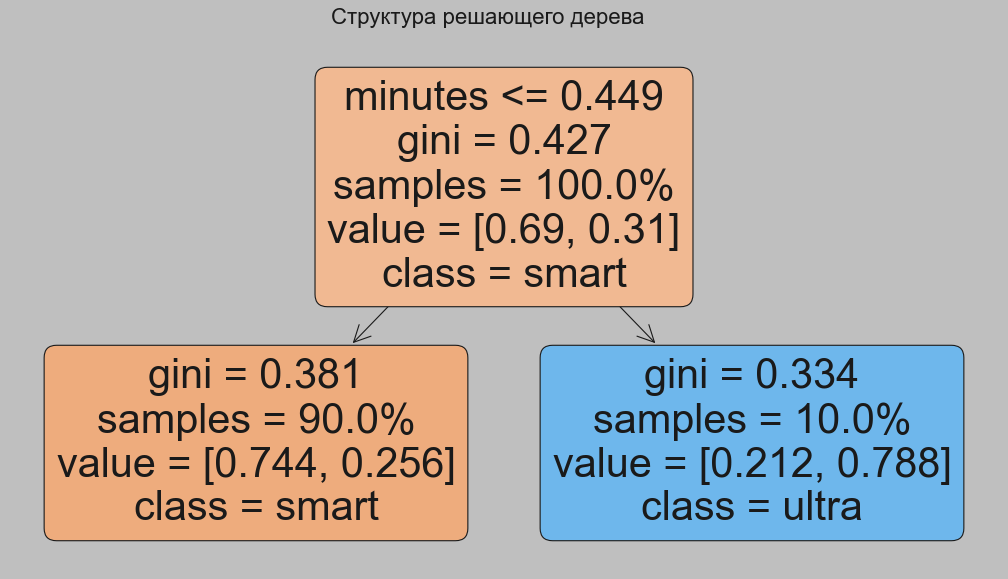

In [35]:
import sklearn
with mpl.style.context("classic"):

    fig, ax = plt.subplots(1, figsize=(16,8))
    sklearn.tree.plot_tree(simple_tree, feature_names=features_train.columns,class_names=["smart", "ultra"], ax=ax, filled=True,rounded=True,
                          proportion=True)
    fig.suptitle("Структура решающего дерева",fontsize=20)

In [36]:
scaler.inverse_transform([[0, 0.499, 0, 0]])[0][1].round(2)

814.4

Получается, что если минут было израсходовано больше, чем 814.4, то тариф *Ультра*, иначе *Смарт*.

Итак, оценим точность такой простой модели:

In [37]:
simple_tree.score(features_test, target_test).round(3)

0.739

In [38]:
simple_tree.score(features_train, target_train).round(3)

0.748

На ***тестовой*** выборке *0.739*, на ***обучающей*** *0.748*, налицо недообучение, но сейчас не про это.  
Итак, мы трудились не зря, наша главная модель обходит простую модель решающего дерева по точности.

Отсюда, вкупе с данными о значимости признаков, можем сделать вывод, что модель адекватная.

<a id="5_6."></a>
# 6. Вывод

Задание на проект выполнено, построена модель для классификации пользователей по тарифному плану. 
Данную модель возможно использовать в качестве рекомендательной, она сможет подобрать тариф для пользователя, т.к. её точность на незнакомыx данных равна ***0.825***. 